<a href="https://colab.research.google.com/github/NikitaGrunin/laba2/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22homework_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 1

## Импортирование необходимых библиотек

In [1]:
from PIL import Image
from glob import glob
import time
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms as T
from tensorflow import summary as tfsummary
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os

In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Чтение тренировочной и тестовой выборки

Инструкция для скачивания и загрузки фотографий в Сolab находится в github

In [4]:
heigth_width = 32

CLASSES = ['Глаз', 'Бабочка', 'Ракета'] # Здесь требуется указать ваши классы

images = []
images_t = []
classes = []
classes_t = []

for CLASS in range(0, len(CLASSES)):
  path_class_1 = "/content/%s/*.*"%CLASSES[CLASS]
  i=0
  for photo in glob(path_class_1):
      i+=1
      img = Image.open(photo).convert('RGB')
      img = img.resize((heigth_width, heigth_width), Image.ANTIALIAS)
      if i > int(len(os.listdir("/content/%s/"%CLASSES[CLASS]))*0.8):
          images_t.append(np.asarray(img))
          classes_t.append(np.asarray(CLASS))
      else:
          images.append(np.asarray(img))
          classes.append(np.asarray(CLASS))

    
train_X = np.array(images)
train_y = np.array(classes)

test_X = np.array(images_t)
test_y = np.array(classes_t)

Аугментация данных

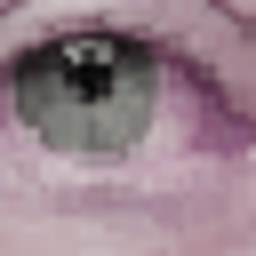

In [5]:
class CifarDataset(Dataset):
     def __init__(self, X, y, transform=None, p=0.0):
         assert X.size(0) == y.size(0)
         super(Dataset, self).__init__()
         self.X = X
         self.y = y
         self.transform = transform
         self.prob = p
        
     def __len__(self):
         return self.y.size(0)
        
     def __getitem__(self, index):
        x = self.X[index]
        if self.transform and np.random.random()<self.prob:
            x = self.transform(x.permute(2, 0, 1)/255.).permute(1, 2, 0)*255.
        y = self.y[index]
        return x, y

transform = T.Compose([
     T.ColorJitter(brightness=0.1, contrast=0.5, saturation=0.6, hue=0.2),
     T.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.4, 2.0),
                    shear=5),
     #T.RandomInvert(0,4)
])
#transform = T.GaussianBlur(kernel_size = 1,sigma = (0.2, 2.0))
#transform = T.AutoAugment(T.AutoAugmentPolicy.CIFAR10)

Image.fromarray((transform(torch.Tensor(train_X[50]).permute(2, 0, 1)/255.).\
                 permute(1, 2, 0).numpy()*255.).astype(np.uint8)).\
                 resize((256, 256))

###Приведение фотографий к требуемому размеру

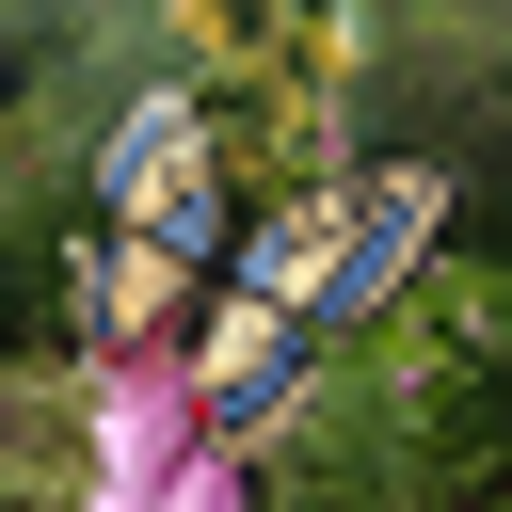

In [6]:
Image.fromarray(train_X[123]).resize((512,512))

##Создание Pytorch DataLoader'a

In [7]:
batch_size = 32
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fc277bf2b10>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fc277bf2ad0>}

##Создание Pytorch модели многослойного перцептрона с одним скрытым слоем

In [15]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1) # nhwc -> nm

class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32*32*3, hidden_size),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)

HIDDEN_SIZE = 10
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): Linear(in_features=10, out_features=3, bias=True)
  )
)

##Выбор функции потерь и оптимизатора градиентного спуска

In [16]:
# добавляем сглаживание целевых меток, это увеличит значение функции потерь
# но полученная модель будет более устойчивой к выбросам в обучающей выборке
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# используется SGD c momentum и L2-регуляризацией весов
optimizer = optim.SGD(model.parameters(), lr=3e-3, momentum=0.9,
                      weight_decay=1e-5)
# добавляем постепенное уменьшение шага обучения каждые 200 эпох
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=240, gamma=0.5)

##Обучение модели по эпохам

In [17]:
EPOCHS = 250
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    running_loss = 0.0
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
print('Обучение закончено')

[1,     9] loss: 0.977
[1,     3] val loss: 0.705
[2,     9] loss: 0.699
[2,     3] val loss: 0.520
[3,     9] loss: 0.614
[3,     3] val loss: 0.656
[4,     9] loss: 0.514
[4,     3] val loss: 0.439
[5,     9] loss: 0.514
[5,     3] val loss: 0.496
[6,     9] loss: 0.506
[6,     3] val loss: 0.646
[7,     9] loss: 0.460
[7,     3] val loss: 0.500
[8,     9] loss: 0.432
[8,     3] val loss: 0.465
[9,     9] loss: 0.447
[9,     3] val loss: 0.441
[10,     9] loss: 0.438
[10,     3] val loss: 0.437
[11,     9] loss: 0.423
[11,     3] val loss: 0.590
[12,     9] loss: 0.435
[12,     3] val loss: 0.420
[13,     9] loss: 0.408
[13,     3] val loss: 0.438
[14,     9] loss: 0.408
[14,     3] val loss: 0.503
[15,     9] loss: 0.418
[15,     3] val loss: 0.413
[16,     9] loss: 0.385
[16,     3] val loss: 0.426
[17,     9] loss: 0.411
[17,     3] val loss: 0.416
[18,     9] loss: 0.410
[18,     3] val loss: 0.681
[19,     9] loss: 0.377
[19,     3] val loss: 0.415
[20,     9] loss: 0.382
[20,  

##Проверка качества модели по классам на обучающей и тестовой выборках

In [18]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

        Глаз     1.0000    1.0000    1.0000        87
     Бабочка     1.0000    1.0000    1.0000        95
      Ракета     1.0000    1.0000    1.0000        84

    accuracy                         1.0000       266
   macro avg     1.0000    1.0000    1.0000       266
weighted avg     1.0000    1.0000    1.0000       266

--------------------------------------------------
test
              precision    recall  f1-score   support

        Глаз     0.9167    1.0000    0.9565        22
     Бабочка     0.9545    0.8750    0.9130        24
      Ракета     0.9524    0.9524    0.9524        21

    accuracy                         0.9403        67
   macro avg     0.9412    0.9425    0.9406        67
weighted avg     0.9414    0.9403    0.9396        67

--------------------------------------------------


##Сохранение модели в ONNX

In [19]:
# сохраниение модели
# ПЕРВЫЙ СПОСОБ: сохранение параметров
PATH = 'cifar.pth'
torch.save(model.state_dict(), PATH)
# загрузка
new_model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
new_model.load_state_dict(torch.load(PATH))
new_model.eval()

# ВТОРОЙ СПОСОБ: сохранение всей архитектуры
PATH2 = 'cifar.pt'
torch.save(model, PATH2)
# загрузка
new_model_2 = torch.load(PATH2)
new_model_2.eval()

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [20]:
# входной тензор для модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})